### IMPORTY  

In [10]:
import queue
import numpy as np
from typing import List, Tuple
import math
import datetime
import pandas as pd
import itertools
from random_gen import RandomNumberGenerator2
import time
from multiprocessing import Pool, cpu_count
import random
import matplotlib.pyplot as plt
import json
import pickle
from tabulate import tabulate


### GENERACJA DANYCH

In [11]:
seed = 42
np.random.seed(seed)
random.seed(seed)
INPUT_SIZE = 100
   
random_gen = RandomNumberGenerator2(seedVaule=seed) # type: ignore
p, d = random_gen.generate_input(INPUT_SIZE)

### ALGORYTM

In [12]:
class AlgorithmSA:
    def __init__(self, 
                 iterations:int,
                 alpha=0.995
                 ):
        self.iterations = iterations
        self.alpha = alpha
        
        
    def eval_end_times(self, p) -> List:
        C = []
        length = p[0].shape[0]
        for i in range(length):
            if i == 0:
                C.append(p[0][i] + p[1][i] + p[2][i])
            else:
                tmp = C[i-1] + p[0][i] + p[1][i] + p[2][i]
                C.append(tmp)
        return C
        
        
    
    def eval_criterion(self, p, d) -> Tuple:
        kry_3 = None
        kry_4 = 0
        kry_5 = None
        kry_6 = 0
        C = self.eval_end_times(p)
        length = p[0].shape[0]
        for i in range(length):
            diff = C[i] - d[i]
            
            if kry_5 is None or kry_5 < diff:
                kry_5 = diff
            
            diff_pos = max(diff, 0)
            if kry_3 is None or kry_3 < diff_pos:
                kry_3 = diff_pos
            kry_4 += diff_pos
            kry_6 += diff                
        return [kry_3, kry_4, kry_5, kry_6]              
        
    
    def get_initial(self, p, d):
        length = len(p[0])
        new_order = np.random.permutation(length)
        p = [p[0][new_order], p[1][new_order], p[2][new_order]]
        d = d[new_order]
        return p, d
    
    def get_neighbor(self, p, d):
        neighbor = p.copy()
        i, j = random.sample(range(p[0].shape[0]), 2)
        neighbor[0][i], neighbor[0][j] = neighbor[0][j], neighbor[0][i]
        neighbor[1][i], neighbor[1][j] = neighbor[1][j], neighbor[1][i]
        neighbor[2][i], neighbor[2][j] = neighbor[2][j], neighbor[2][i]
        
        neighbor_d = d.copy()
        neighbor_d[i], neighbor_d[j] = neighbor_d[j], neighbor_d[i]
        return neighbor, neighbor_d
                        
    def dominates(self, a, b):
        return np.all(a <= b) and np.any(a < b)
    
    def calc_prob(self, it):
        try:
            return math.pow(self.alpha, it)
        except Exception as e:
            return 0.0001
    
    def run(self, p, d):
        P = []
        it = 0
        p, d = self.get_initial(p, d)
        x = self.eval_criterion(p, d)
        P.append(x)
        
        while it < self.iterations:
            p_neigh, d_neigh = self.get_neighbor(p, d)
            x_prim = self.eval_criterion(p_neigh, d_neigh)
            
            if self.dominates(x_prim, x):
                p = p_neigh
                d = d_neigh
                x = x_prim
                P.append(x)
            elif (random.random() < self.calc_prob(it)):
                p = p_neigh
                d = d_neigh
                x = x_prim
                P.append(x)
            it += 1
        
        F = P.copy()
        for a in range(len(F)):
            for b in range(len(F)):
                if F[a] is not None and F[b] is not None and a != b and self.dominates(F[b], F[a]):
                    F[a] = None
                    break
        F = [f for f in F if f is not None]
        F = np.array(F)
        
        return F, P

### ZAPISANIE WYNIKÓW - WYWOŁANIE ALGORYTMU

In [13]:
reps = 5
REPETITIONS = 1

results = []

# Gathering results for different max iterations
algorithm = AlgorithmSA(iterations=1600)

for i in range(reps):
    F, P = algorithm.run(p, d)
    print(len(F))
    results.append({
        "nr": i,
        "kry_3": F[0][0],
        "kry_4": F[0][1],
        "kry_5": F[0][2],
        "kry_6": F[0][3]
    })
    df = pd.DataFrame(results)

1
1
1
1
1


In [14]:
def create_paths(dir, n: int):
    return f'{dir}/n_{n}_results.pkl', f'{dir}/n_{n}_results_for_hvi.pkl'

DIR = 'res/zad3'
RESULTS_PATH, RESULTS_FOR_HVI_PATH = create_paths(DIR, INPUT_SIZE)

In [15]:
with open(RESULTS_PATH, 'wb') as f:
    pickle.dump(results, f)

### LOAD DATA

In [16]:
with open(RESULTS_PATH, 'rb') as f:
    results_loaded = pickle.load(f)

In [17]:
print(tabulate(df, headers='keys', tablefmt='psql'))

+----+------+---------+---------+---------+---------+
|    |   nr |   kry_3 |   kry_4 |   kry_5 |   kry_6 |
|----+------+---------+---------+---------+---------|
|  0 |    0 |    8804 |  283732 |    8804 |  184473 |
|  1 |    1 |    8197 |  274847 |    8197 |  181358 |
|  2 |    2 |    8207 |  290660 |    8207 |  202729 |
|  3 |    3 |    8856 |  285456 |    8856 |  184123 |
|  4 |    4 |    8290 |  259807 |    8290 |  163975 |
+----+------+---------+---------+---------+---------+


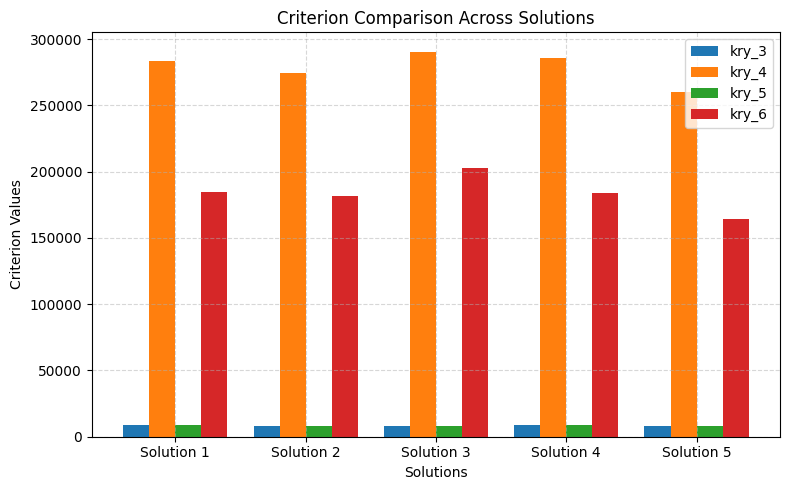

In [23]:
criteria_cols = ['kry_3', 'kry_4', 'kry_5', 'kry_6']
data = df[criteria_cols].values

num_solutions = data.shape[0]
num_criteria = data.shape[1]
x = np.arange(num_solutions)  # [0, 1, 2] for 3 solutions
bar_width = 0.2

fig, ax = plt.subplots(figsize=(8, 5))

# Plot each criterion as a group of bars
for i in range(num_criteria):
    ax.bar(x + i * bar_width, data[:, i], width=bar_width, label=criteria_cols[i])

# Set axis labels and ticks
ax.set_xlabel('Solutions')
ax.set_ylabel('Criterion Values')
ax.set_title('Criterion Comparison Across Solutions')
ax.set_xticks(x + bar_width * (num_criteria - 1) / 2)
ax.set_xticklabels([f'Solution {i+1}' for i in range(num_solutions)])
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

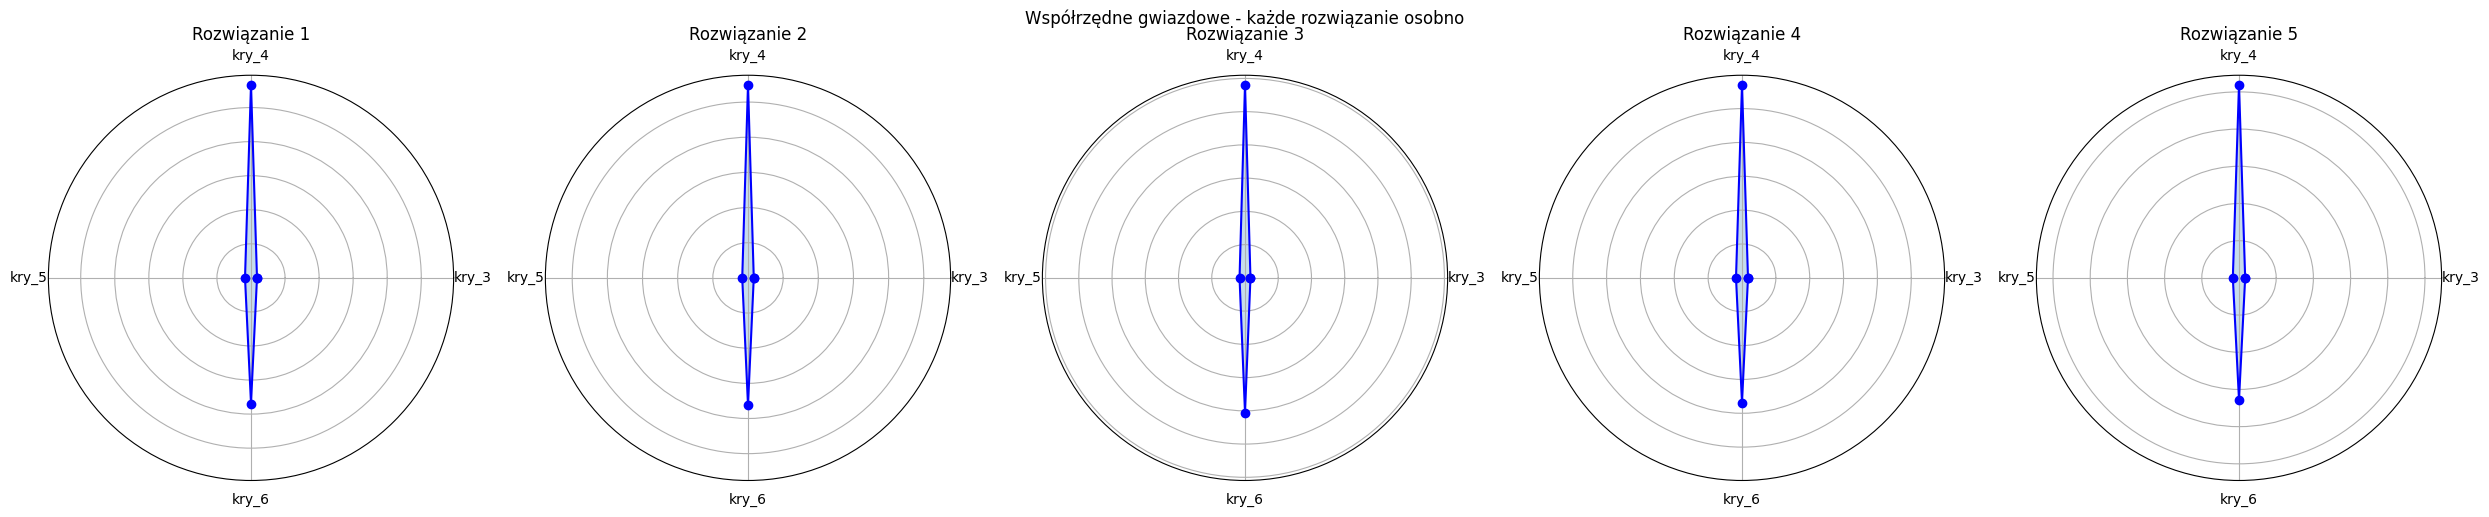

In [24]:
criteria = ['kry_3', 'kry_4', 'kry_5', 'kry_6']
num_criteria = len(criteria)
angles = np.linspace(0, 2 * np.pi, num_criteria, endpoint=False).tolist()
angles += angles[:1]  # zamknięcie wykresu

fig, axs = plt.subplots(1, len(df), figsize=(5*len(df), 5), subplot_kw=dict(polar=True))

for idx, (ax, (_, row)) in enumerate(zip(axs, df.iterrows())):
    values = row[criteria].tolist()
    values += values[:1]
    ax.plot(angles, values, 'b-o')
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(criteria)
    ax.set_yticklabels([])
    ax.set_title(f'Rozwiązanie {idx+1}')

plt.suptitle('Współrzędne gwiazdowe - każde rozwiązanie osobno')
plt.tight_layout()
plt.show()

In [ ]:
def draw_faces(data):

    fig, ax = plt.subplots()
    fig.set_figwidth(7)
    fig.set_figheight(7)

    number_faces = len(data)
    if number_faces != 4:
        return
    face_area_width = 0.5
    face_width = face_area_width * 0.5
    print()
    midX = [0.25, 0.75, 0.25, 0.75]
    midY = [0.75, 0.75, 0.25, 0.25]
    for i, face in enumerate(data):
        okay = True
        for val in face:
            if val > 1.0 or val < 0.0:
                okay = False
                break

        if okay:
            # face
            shape = pat.Ellipse((midX[i], midY[i]), face_width * (1 + face[0] * 0.9), face_width, angle = 0.0, color='white', ec='black')
            ax.add_patch(shape)

            eye_gap = 0.2
            eye_level = 0.15
            eye_size = 0.1 # * (1.0 - face[1] * 0.75)
            pupil_size = eye_size * 0.35
            brow_size = eye_size * 2.5
            nose_size = 0.3 + 0.1 * face[2]
            nose_width = 0.1 + 0.2 * face[2]
            lips_lift = 10 * math.pow(face[3], 5) - 0.1
            lips_size = 0.3 + 10 * math.pow(face[3], 5)

            c1 = 3.14 * 2 * face_width * lips_size
            c2 = (3.14 * 2 * face_width * 0.3)

            lips_degrees = (70 / (c1 / c2)) * (1.0 - face[3] * 0.75)

            # 0     45
            # 0.33
            # 0.67
            # 1     2

            # left eye
            shape = plt.Circle((midX[i] - face_width * eye_gap, midY[i] + face_width * eye_level), face_width * eye_size, color='white', ec='black')
            ax.add_patch(shape)
            # left pupil
            shape = plt.Circle((midX[i] - face_width * (eye_gap - eye_size * 0.75 * face[1]), midY[i] + face_width * eye_level), face_width * pupil_size, color='black', ec='black')
            ax.add_patch(shape)
            # left brow
            shape = pat.Ellipse((midX[i] - face_width * eye_gap * 0.9, midY[i] + face_width * eye_gap * 1.5), face_width * brow_size, face_width * brow_size * 0.03, angle = 0.0 - face[1] * 45, color='black', ec='black')
            ax.add_patch(shape)

            # right eye
            shape = plt.Circle((midX[i] + face_width * eye_gap, midY[i] + face_width * eye_level), face_width * eye_size, color='white', ec='black')
            ax.add_patch(shape)
            # right pupil
            shape = plt.Circle((midX[i] + face_width * (eye_gap - eye_size * 0.75 * face[1]), midY[i] + face_width * eye_level), face_width * pupil_size, color='black', ec='black')
            ax.add_patch(shape)
            # right brow
            shape = pat.Ellipse((midX[i] + face_width * eye_gap * 0.9, midY[i] + face_width * eye_gap * 1.5), face_width * brow_size, face_width * brow_size * 0.03, angle = 0.0 + face[1] * 45, color='black', ec='black')
            ax.add_patch(shape)

            # nose
            shape = pat.Polygon(
                [
                (midX[i], midY[i] + face_width * 0.2),
                (midX[i] - face_width * nose_width / 2, midY[i] + face_width * (0.2 - nose_size)),
                (midX[i] + face_width * nose_width / 2, midY[i] + face_width * (0.2 - nose_size))
                ], color='white', ec='black', closed=False)
            ax.add_patch(shape)

            # lips
            shape = pat.Arc((midX[i], midY[i] + face_width * lips_lift), face_width * lips_size * 2, face_width * lips_size * 2, angle = 0.0, theta1=-90 - lips_degrees, theta2=-90 + lips_degrees, color='black', ec='black')
            ax.add_patch(shape)

            # face = pat.Ellipse((0.5, 0.5), 1.0, 0.5, angle = 0.0, color='white', ec='black')
            # ax.add_patch(face)
            # rect = pat.Rectangle((0, 0), 1, 1, linewidth=10, edgecolor='black', facecolor='none')
            # ax.add_patch(rect)

            ax.axis('off')
            plt.show()